<center>基于波函数的流体超分辨研究</center>

# 问题描述


传统的超分辨是给定图片a，经过超分辨能够得到精度更高的图片b

我们希望能够在超分辨模型前后进行结构的调整，使得其能够自适应涡旋流体超分辨，为方便后续研究，我们暂且将这个方法的名字成为$Clebsch$流体超分辨。

$Clebsch$流体超分辨分为四个步骤：
我们首先有一些流体的图片集，我们是能够已知其图片的结构的，即网格数据，和网格对应的速度场。
其次，我们能够知道双分量波函数是可以经过公式转换得到对应速度场的，双分量波函数形如$\psi = a+bi+cj+dk$

1. 从任意一张已知的图片出发，我们假设该图片是$128\times 128$，经过$model_A$后我们能够找到$a,b,c,d$，与之对应的，$a,b,c,d$每一个单独的量都应该是$128\times 128$

2. 我们将得到的$a,b,c,d$再经过一个$model_B$，这个$model_B$是一个超分辨模型，然后我们将得到对应的$a,b,c,d$，我们假设其分辨率从128提高到了256

3. 我们需要再训练一个从abcd到速度场的$model_c$，然后我们就能得到256的速度场了。

我们希望经过我们改进后的超分辨模型，能够更加适应用于涡旋的流体现象，因为我们能够chern的文章中验证通过波函数的方法能够较好的捕捉涡结构。

为了能够得到上面的模型，我们需要逐步训练各个部分模型，这项工作，只是进行一个简单的尝试，因此，我们会对采用精度较低的图片，以提高模型的训练速度，来验证本项工作的可行性。

# 初始案例构建

函数 \(a(x, y)\)、\(b(x, y)\)、\(c(x, y)\) 和 \(d(x, y)\) 定义如下：
\begin{align*}
    H(x) &= 
    \begin{cases} 
      \frac{x}{2} & \text{如果 } 0 \leq x \leq \pi \\
      \pi - \frac{x}{2} & \text{如果 } \pi < x \leq 2\pi 
    \end{cases} \\
    a(x, y) &= \cos[H(x)] \cos\left(\frac{\cos(y) (2 - \cos(x))}{\hbar}\right), \\
    b(x, y) &= \cos[H(x)] \sin\left(\frac{\cos(y) (2 - \cos(x))}{\hbar}\right), \\
    c(x, y) &= \sin[H(x)] \cos\left(\frac{\cos(y) (2 + \cos(x))}{\hbar}\right), \\
    d(x, y) &= -\sin[H(x)] \sin\left(\frac{\cos(y) (2 + \cos(x))}{\hbar}\right).
\end{align*}
其中，$\hbar $是一个常数（为了简化，设为1）。

速度场计算
$$
\mathbf{u} = \hbar(a \mathbf \nabla b-b\mathbf \nabla a + c\mathbf \nabla d - d\mathbf \nabla c)
$$

速度场分量 $u_x$ 和 $u_y$ 使用 $a$、$b$、$c$、$d$ 的梯度计算得到：
$$
\begin{align*}
    \nabla a &= \left(\frac{\partial a}{\partial x}, \frac{\partial a}{\partial y}\right), \\
    \nabla b &= \left(\frac{\partial b}{\partial x}, \frac{\partial b}{\partial y}\right), \\
    \nabla c &= \left(\frac{\partial c}{\partial x}, \frac{\partial c}{\partial y}\right), \\
    \nabla d &= \left(\frac{\partial d}{\partial x}, \frac{\partial d}{\partial y}\right).
\end{align*}
$$

速度场的计算公式为：
\begin{align*}
    u_x &= \hbar \left(a \frac{\partial b}{\partial x} - b \frac{\partial a}{\partial x} + c \frac{\partial d}{\partial x} - d \frac{\partial c}{\partial x}\right), \\
    u_y &= \hbar \left(a \frac{\partial b}{\partial y} - b \frac{\partial a}{\partial y} + c \frac{\partial d}{\partial y} - d \frac{\partial c}{\partial y}\right).
\end{align*}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# 定义常数
hbar = 1

# 定义 H(x)
def H(x):
    return np.where((0 <= x) & (x <= np.pi), x / 2, np.pi - x / 2)

# 定义函数 a, b, c, d
def a(x, y):
    return np.cos(H(x)) * np.cos(np.cos(y) * (2 - np.cos(x)) / hbar)

def b(x, y):
    return np.cos(H(x)) * np.sin(np.cos(y) * (2 - np.cos(x)) / hbar)

def c(x, y):
    return np.sin(H(x)) * np.cos(np.cos(y) * (2 + np.cos(x)) / hbar)

def d(x, y):
    return -np.sin(H(x)) * np.sin(np.cos(y) * (2 + np.cos(x)) / hbar)

# 计算梯度
def gradient(f, x, y, eps=1e-5):
    f_x = (f(x + eps, y) - f(x - eps, y)) / (2 * eps)
    f_y = (f(x, y + eps) - f(x, y - eps)) / (2 * eps)
    return f_x, f_y

# 计算速度场
def compute_velocity_field_np(x, y, dx, dy):
    # 使用内置的np 求解梯度
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = np.gradient(a_val, dx, dy)
    b_grad_x, b_grad_y = np.gradient(b_val, dx, dy)
    c_grad_x, c_grad_y = np.gradient(c_val, dx, dy)
    d_grad_x, d_grad_y = np.gradient(d_val, dx, dy)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y

def compute_velocity_field_FD(x, y):
    # 有限差分进行计算
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = gradient(a, x, y)
    b_grad_x, b_grad_y = gradient(b, x, y)
    c_grad_x, c_grad_y = gradient(c, x, y)
    d_grad_x, d_grad_y = gradient(d, x, y)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y

In [ ]:
size = 128
x = np.linspace(0, 2 * np.pi, size)
y = np.linspace(0, 2 * np.pi, size)
X, Y = np.meshgrid(x, y)

In [ ]:
# 计算步长
dx = x[1] - x[0]
dy = y[1] - y[0]

In [ ]:
U_x, U_y = compute_velocity_field_np(X, Y, dx, dy)

U_x_FD, U_y_FD = compute_velocity_field_FD(X, Y)

# 计算速度场的大小
U_magnitude = np.sqrt(U_x**2 + U_y**2)

U_magnitude_FD = np.sqrt(U_x_FD**2 + U_y_FD**2)

## 可视化速度场

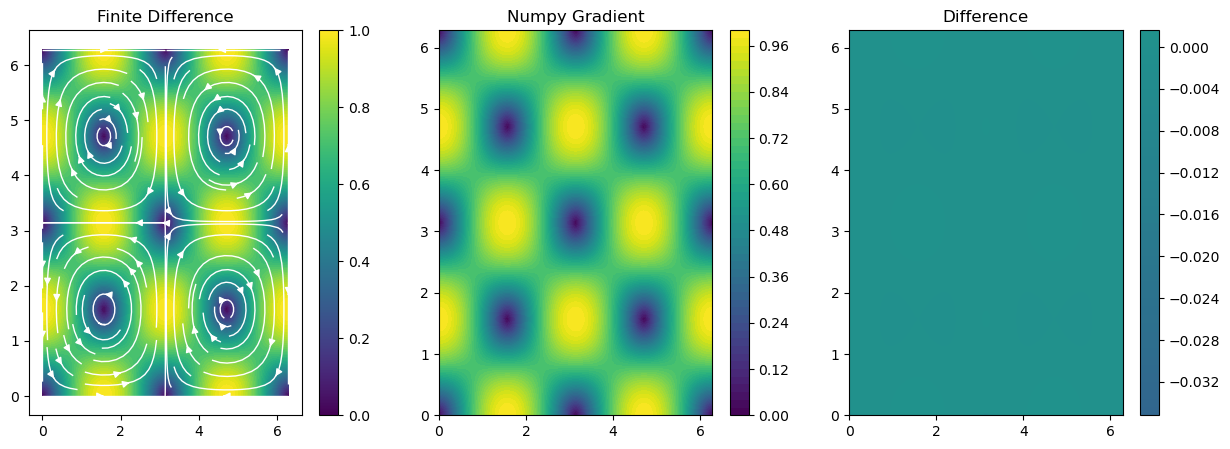

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.contourf(X, Y, U_magnitude_FD, levels=50, cmap='viridis')
plt.streamplot(X, Y, U_x_FD, U_y_FD, color='white', linewidth=1)
plt.title('Finite Difference')
plt.colorbar()


plt.subplot(1,3,2)
plt.contourf(X, Y, U_magnitude, levels=50, cmap='viridis')
# plt.streamplot(X, Y, U_x, U_y, color='white', linewidth=1)
plt.title('Numpy Gradient')
plt.colorbar()


plt.subplot(1,3,3)
plt.contourf(X, Y, U_magnitude_FD-U_magnitude, levels=50, cmap='viridis', vmin=-0.1, vmax=0.1)
plt.title('Difference')
plt.colorbar()

plt.show()


## 可视化涡量场

In [ ]:
# 计算旋度
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy

In [ ]:
# 计算旋度
vort = vorticity(U_x, U_y, dx, dy)
vort_FD = vorticity(U_x_FD, U_y_FD, dx, dy)

# 归一化旋度
max_vort = np.max(np.abs(vort))
vort_normalized = vort / max_vort if max_vort != 0 else vort

max_vort_FD = np.max(np.abs(vort_FD))
vort_normalized_FD = vort_FD / max_vort_FD if max_vort_FD != 0 else vort_FD



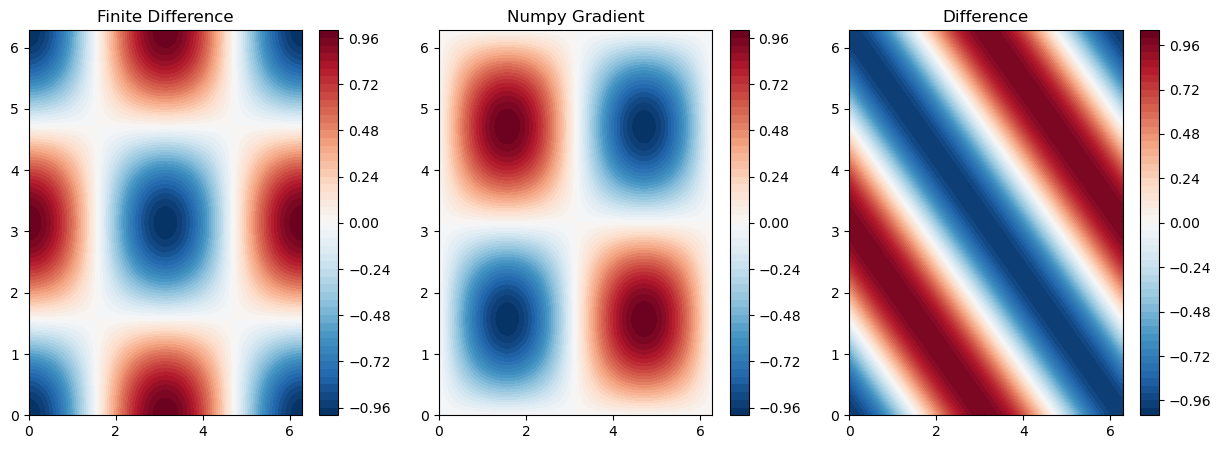

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.contourf(X, Y, vort_normalized_FD, levels=50, cmap='RdBu_r')
plt.title('Finite Difference')
plt.colorbar()

plt.subplot(1,3,2)
plt.contourf(X, Y, vort_normalized, levels=50, cmap='RdBu_r')
plt.title('Numpy Gradient')
plt.colorbar()

plt.subplot(1,3,3)
plt.contourf(X, Y, vort_normalized_FD-vort_normalized, levels=50, cmap='RdBu_r')
plt.title('Difference')
plt.colorbar()

plt.show()

从这个结果看，我们采用np的内置梯度求导函数的结果与Zhaoyuan Meng(2023)的文章从视觉上看是一直的，而采用有限差分的求梯度似乎存在一定的问题，这个问题，在有np内置梯度函数的情况下，目前不太影响我们的模型，因此，我们当前先记录下这个问题，继续进行后续模型的训练。


根据上述文中代码所属，我们最后选择是：
1. 速度变量的分量是：`U_x, U_y, U_magnitude`
2. 归一化后的涡量是：`vort_normalized`

##  模型A训练

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import os

In [93]:
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [103]:
class FluidDataset(Dataset):
    def __init__(self, U_x, U_y, U_magnitude, a, b, c, d,transform=None):
        self.U_x = U_x
        self.U_y = U_y
        self.U_magnitude = U_magnitude
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.transform = transform

    def __len__(self):
        return len(self.U_x)
    
    def __getitem__(self, idx):
        inputs = np.stack([self.U_x[idx], self.U_y[idx], self.U_magnitude[idx]], axis=0)
        targets = np.stack([self.a[idx], self.b[idx], self.c[idx], self.d[idx]], axis=0)
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

In [104]:
# 定义数据增强函数
def data_augmentation(inputs):
    if np.random.rand() > 0.5:
        inputs = np.flip(inputs, axis=1).copy()  # 水平翻转
    if np.random.rand() > 0.5:
        inputs = np.flip(inputs, axis=2).copy()  # 垂直翻转
    return inputs

In [105]:
def load_data():
    size =128
    x= np.linspace(0, 2 * np.pi, size)
    y = np.linspace(0, 2 * np.pi, size)
    X, Y = np.meshgrid(x, y)

    hbar = 1

    def H(x):
        return np.where((0 <= x) & (x <= np.pi), x / 2, np.pi - x / 2)

    # 定义a(x, y)函数
    def a(x, y):
        return np.cos(H(x)) * np.cos(np.cos(y) * (2 - np.cos(x)) / hbar)

    # 定义b(x, y)函数
    def b(x, y):
        return np.cos(H(x)) * np.sin(np.cos(y) * (2 - np.cos(x)) / hbar)

    # 定义c(x, y)函数
    def c(x, y):
        return np.sin(H(x)) * np.cos(np.cos(y) * (2 + np.cos(x)) / hbar)

    # 定义d(x, y)函数
    def d(x, y):
        return -np.sin(H(x)) * np.sin(np.cos(y) * (2 + np.cos(x)) / hbar)

    # 计算速度场的函数
    def compute_velocity_field_np(x, y, dx, dy):
        # 计算a, b, c, d的值
        a_val = a(x, y)
        b_val = b(x, y)
        c_val = c(x, y)
        d_val = d(x, y)

        # 计算a, b, c, d的梯度
        a_grad_x, a_grad_y = np.gradient(a_val, dx, dy)
        b_grad_x, b_grad_y = np.gradient(b_val, dx, dy)
        c_grad_x, c_grad_y = np.gradient(c_val, dx, dy)
        d_grad_x, d_grad_y = np.gradient(d_val, dx, dy)

        # 计算速度场的x和y分量
        u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
        u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

        return u_x, u_y
    
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    # 计算速度场的x和y分量
    U_x, U_y = compute_velocity_field_np(X, Y, dx, dy)
    # 计算速度场的大小
    U_magnitude = np.sqrt(U_x**2 + U_y**2)

    # 计算a, b, c, d的值
    a_data = a(X, Y)
    b_data = b(X, Y)
    c_data = c(X, Y)
    d_data = d(X, Y)

    # 重复数据，生成多样本
    num_samples = 100
    U_x = np.tile(U_x, (num_samples, 1, 1))
    U_y = np.tile(U_y, (num_samples, 1, 1))
    U_magnitude = np.tile(U_magnitude, (num_samples, 1, 1))
    a_data = np.tile(a_data, (num_samples, 1, 1))
    b_data = np.tile(b_data, (num_samples, 1, 1))
    c_data = np.tile(c_data, (num_samples, 1, 1))
    d_data = np.tile(d_data, (num_samples, 1, 1))

    return U_x, U_y, U_magnitude, a_data, b_data, c_data, d_data


In [106]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),         
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 4, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [107]:
# 训练模型函数
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=50, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')



In [108]:
# 评估模型
def evaluate_model(model, dataloader, criterion, device='cpu'):
    model.to(device)  # 将模型移动到指定设备
    model.eval()  # 设置模型为评估模式
    running_loss = 0.0
    with torch.no_grad():  # 关闭梯度计算
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # 将数据移动到指定设备
            outputs = model(inputs)  # 前向传播
            loss = criterion(outputs, targets)  # 计算损失
            running_loss += loss.item() * inputs.size(0)  # 累加损失

    total_loss = running_loss / len(dataloader.dataset)  # 计算总损失
    print(f'Evaluation Loss: {total_loss:.4f}')  # 打印评估损失


In [109]:
# 保存模型
def saved_models(model, filename):
    torch.save(model.state_dict(), filename)

# 加载模型
def load_model(model, filename):
    model.load_state_dict(torch.load(filename))

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [111]:
U_x, U_y, U_magnitude, a_data, b_data, c_data, d_data = load_data()

# dataset = FluidDataset(U_x, U_y, U_magnitude, a_data, b_data, c_data, d_data)
dataset = FluidDataset(U_x, U_y, U_magnitude, a_data, b_data, c_data, d_data, transform=data_augmentation)


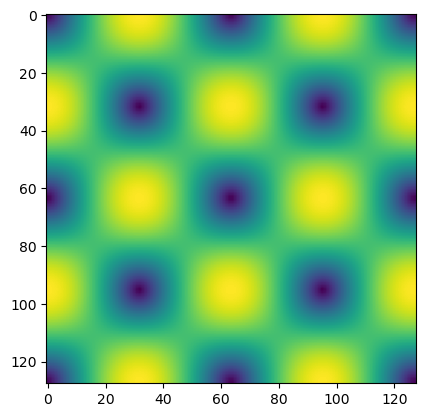

In [112]:
plt.imshow(U_magnitude[0])

In [113]:
# 划分训练集和测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [137]:
# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [138]:
# 初始化模型
model = UNet()
# 定义损失函数
criterion = nn.MSELoss()
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


In [139]:
train_model(model, train_dataloader, criterion, optimizer, scheduler, num_epochs=1000, device=device)


Epoch 1/1000, Loss: 0.2414
Epoch 2/1000, Loss: 0.2376
Epoch 3/1000, Loss: 0.2332
Epoch 4/1000, Loss: 0.2271
Epoch 5/1000, Loss: 0.2197
Epoch 6/1000, Loss: 0.2229
Epoch 7/1000, Loss: 0.2154
Epoch 8/1000, Loss: 0.2120
Epoch 9/1000, Loss: 0.2112
Epoch 10/1000, Loss: 0.2088
Epoch 11/1000, Loss: 0.2047
Epoch 12/1000, Loss: 0.2012
Epoch 13/1000, Loss: 0.1999
Epoch 14/1000, Loss: 0.1978
Epoch 15/1000, Loss: 0.1974
Epoch 16/1000, Loss: 0.1976
Epoch 17/1000, Loss: 0.1969
Epoch 18/1000, Loss: 0.1966
Epoch 19/1000, Loss: 0.1959
Epoch 20/1000, Loss: 0.1949
Epoch 21/1000, Loss: 0.1941
Epoch 22/1000, Loss: 0.1928
Epoch 23/1000, Loss: 0.1921
Epoch 24/1000, Loss: 0.1910
Epoch 25/1000, Loss: 0.1902
Epoch 26/1000, Loss: 0.1897
Epoch 27/1000, Loss: 0.1893
Epoch 28/1000, Loss: 0.1886
Epoch 29/1000, Loss: 0.1883
Epoch 30/1000, Loss: 0.1875
Epoch 31/1000, Loss: 0.1868
Epoch 32/1000, Loss: 0.1859
Epoch 33/1000, Loss: 0.1849
Epoch 34/1000, Loss: 0.1838
Epoch 35/1000, Loss: 0.1825
Epoch 36/1000, Loss: 0.1809
E

In [140]:
saved_models(model, 'modelA_Saved/model_A.pth')

In [141]:
# 加载训练好的模型参数
model =UNet()
load_model(model, 'modelA_Saved/model_A.pth')  

In [142]:
evaluate_model(model, test_dataloader, criterion, device=device)

Evaluation Loss: 0.0916


Predictions shape: torch.Size([20, 4, 128, 128])
a_pred shape: torch.Size([20, 128, 128])
b_pred shape: torch.Size([20, 128, 128])
c_pred shape: torch.Size([20, 128, 128])
d_pred shape: torch.Size([20, 128, 128])
Sample prediction for a: tensor([[0.3173, 0.3303, 0.3448,  ..., 0.3223, 0.3562, 0.3851],
        [0.4474, 0.5537, 0.5106,  ..., 0.5405, 0.5190, 0.4656],
        [0.4799, 0.5185, 0.4990,  ..., 0.5091, 0.5109, 0.5250],
        ...,
        [0.4203, 0.5224, 0.5027,  ..., 0.5523, 0.5650, 0.4921],
        [0.4846, 0.5016, 0.4967,  ..., 0.5240, 0.5508, 0.5685],
        [0.2818, 0.3203, 0.2861,  ..., 0.3310, 0.3204, 0.3517]],
       device='cuda:0')
Sample prediction for b: tensor([[0.3610, 0.5472, 0.6003,  ..., 0.5179, 0.5965, 0.5319],
        [0.4452, 0.7110, 0.7628,  ..., 0.6901, 0.7744, 0.5594],
        [0.5338, 0.7476, 0.7446,  ..., 0.7409, 0.7463, 0.5790],
        ...,
        [0.4633, 0.7203, 0.7650,  ..., 0.7076, 0.7921, 0.5469],
        [0.5640, 0.7779, 0.7856,  ..., 0.7724,

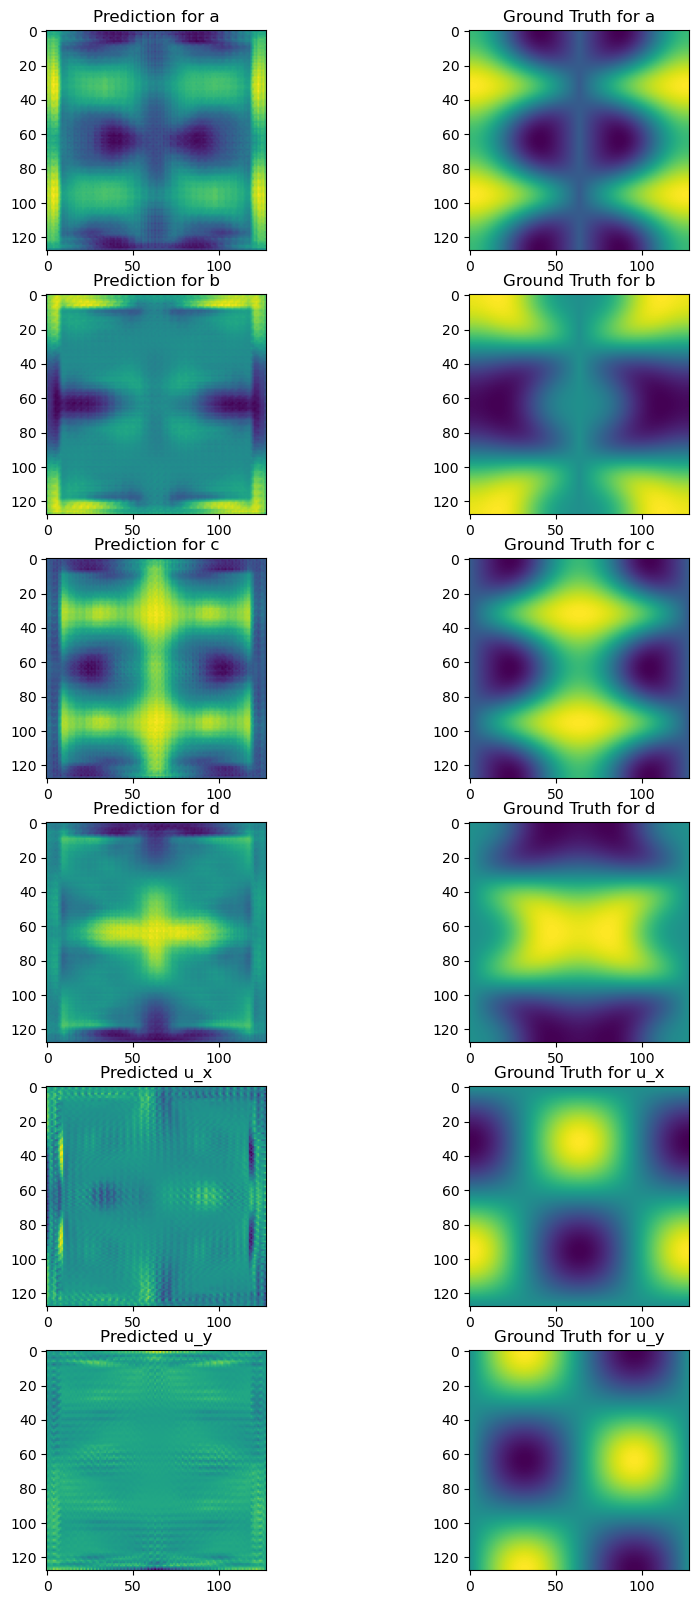

In [143]:
model.to(device)

model.eval()

with torch.no_grad():
    for inputs, _ in test_dataloader:
        inputs = inputs.to(device)
        predictions  = model(inputs)
        print(f'Predictions shape: {predictions.shape}')  # 打印预测结果形状


        a_pred = predictions[:, 0, :, :]
        b_pred = predictions[:, 1, :, :]
        c_pred = predictions[:, 2, :, :]
        d_pred = predictions[:, 3, :, :]

        print(f'a_pred shape: {a_pred.shape}')
        print(f'b_pred shape: {b_pred.shape}')
        print(f'c_pred shape: {c_pred.shape}')
        print(f'd_pred shape: {d_pred.shape}')

        print(f'Sample prediction for a: {a_pred[0]}')
        print(f'Sample prediction for b: {b_pred[0]}')
        print(f'Sample prediction for c: {c_pred[0]}')
        print(f'Sample prediction for d: {d_pred[0]}')

        hbar = 1

        dx = dy = 2 * np.pi / 128  # 计算步长

        a_pred_cpu = a_pred.cpu().numpy()
        b_pred_cpu = b_pred.cpu().numpy()
        c_pred_cpu = c_pred.cpu().numpy()
        d_pred_cpu = d_pred.cpu().numpy()


        a_grad_x, a_grad_y = np.gradient(a_pred_cpu, dx, dy, axis=(2, 1))
        b_grad_x, b_grad_y = np.gradient(b_pred_cpu, dx, dy, axis=(2, 1))
        c_grad_x, c_grad_y = np.gradient(c_pred_cpu, dx, dy, axis=(2, 1))
        d_grad_x, d_grad_y = np.gradient(c_pred_cpu, dx, dy, axis=(2, 1))


        u_x_pred = hbar * (a_pred_cpu * b_grad_x - b_pred_cpu * a_grad_x + c_pred_cpu * d_grad_x - d_pred_cpu * c_grad_x)
        u_y_pred = hbar * (a_pred_cpu * b_grad_y - b_pred_cpu * a_grad_y + c_pred_cpu * d_grad_y - d_pred_cpu * c_grad_y)


        import matplotlib.pyplot as plt

        fig, axs = plt.subplots(6, 2, figsize=(10, 20))


        axs[0, 0].imshow(a_pred[0].cpu().numpy(), cmap='viridis')
        axs[0, 0].set_title('Prediction for a')
        axs[0, 1].imshow(a_data[0], cmap='viridis')
        axs[0, 1].set_title('Ground Truth for a')

        axs[1, 0].imshow(b_pred[0].cpu().numpy(), cmap='viridis')
        axs[1, 0].set_title('Prediction for b')
        axs[1, 1].imshow(b_data[0], cmap='viridis')
        axs[1, 1].set_title('Ground Truth for b')

        axs[2, 0].imshow(c_pred[0].cpu().numpy(), cmap='viridis')
        axs[2, 0].set_title('Prediction for c')
        axs[2, 1].imshow(c_data[0], cmap='viridis')
        axs[2, 1].set_title('Ground Truth for c')

        axs[3, 0].imshow(d_pred[0].cpu().numpy(), cmap='viridis')
        axs[3, 0].set_title('Prediction for d')
        axs[3, 1].imshow(d_data[0], cmap='viridis')
        axs[3, 1].set_title('Ground Truth for d')

        axs[4, 0].imshow(u_x_pred[0], cmap='viridis')
        axs[4, 0].set_title('Predicted u_x')
        axs[4, 1].imshow(U_x[0], cmap='viridis')
        axs[4, 1].set_title('Ground Truth for u_x')

        axs[5, 0].imshow(u_y_pred[0], cmap='viridis')
        axs[5, 0].set_title('Predicted u_y')
        axs[5, 1].imshow(U_y[0], cmap='viridis')
        axs[5, 1].set_title('Ground Truth for u_y')

        

        plt.show()

        break